In [1]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastai.callback.mixup import *
from fastcore.script import *


# Download Imagenette Data and check files

In [3]:
_all_urls=[URLs.IMAGENETTE, URLs.IMAGENETTE_160, URLs.IMAGENETTE_320,
           URLs.IMAGEWOOF, URLs.IMAGEWOOF_160, URLs.IMAGEWOOF_320]

In [5]:
paths = parallel(untar_data, _all_urls, threadpool=True)

# Add additional column with 0% noise

In [14]:
nurl = 'https://raw.githubusercontent.com/tmabraham/noisy_imagenette/main/noisy_imagenette.csv'
wurl = 'https://raw.githubusercontent.com/tmabraham/noisy_imagenette/main/noisy_imagewoof.csv'
npath = untar_data(URLs.IMAGENETTE_160)
wpath = untar_data(URLs.IMAGEWOOF_160)

In [15]:
wdf = pd.read_csv(wurl)
ndf = pd.read_csv(nurl)
ndf

,path,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n03394916,False
...,...,...,...,...,...,...
13389,val/n03425413/n03425413_17521.JPEG,n03425413,n03425413,n03425413,n03425413,True
13390,val/n03425413/n03425413_20711.JPEG,n03425413,n03425413,n03425413,n03425413,True
13391,val/n03425413/n03425413_19050.JPEG,n03425413,n03425413,n03425413,n03425413,True
13392,val/n03425413/n03425413_13831.JPEG,n03425413,n03425413,n03425413,n03425413,True


In [16]:
def get_lbl(p, path=npath):
    pth = (path/p)
    assert pth.exists()
    return pth.parent.name

In [17]:
get_lbl('train/n02979186/n02979186_9036.JPEG')

'n02979186'

In [18]:
ndf['noisy_labels_0'] = ndf.path.apply(get_lbl)
wdf['noisy_labels_0'] = wdf.path.apply(partial(get_lbl, path=wpath))

In [19]:
wdf

,path,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid,noisy_labels_0
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,False,n02115641
1,train/n02115641/n02115641_843.JPEG,n02115641,n02105641,n02115641,n02088364,False,n02115641
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02111889,n02099601,False,n02115641
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02093754,n02115641,False,n02115641
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02088364,False,n02115641
...,...,...,...,...,...,...,...
12949,val/n02089973/n02089973_9351.JPEG,n02089973,n02089973,n02089973,n02089973,True,n02089973
12950,val/n02089973/n02089973_1241.JPEG,n02089973,n02089973,n02089973,n02089973,True,n02089973
12951,val/n02089973/n02089973_4702.JPEG,n02089973,n02089973,n02089973,n02089973,True,n02089973
12952,val/n02089973/n02089973_1040.JPEG,n02089973,n02089973,n02089973,n02089973,True,n02089973


## Save Noise files to imagenette repo

In [20]:
cols = ['path', 'noisy_labels_0', 'noisy_labels_1', 'noisy_labels_5', 'noisy_labels_25','noisy_labels_50', 'is_valid']
ndf = ndf[cols].set_index('path')
wdf = wdf[cols].set_index('path')

ndf.to_csv('/Users/hamelsmu/github/imagenette/noisy_imagenette.csv')
wdf.to_csv('/Users/hamelsmu/github/imagenette/noisy_imagewoof.csv')

### Save noise files into folders

In [21]:
for p in paths:
    if 'woof' in p.name: wdf.to_csv(p/'noisy_imagewoof.csv')
    else: ndf.to_csv(p/'noisy_imagenette.csv')

In [22]:
! tree /Users/hamelsmu/.fastai/data/ -L 2

/Users/hamelsmu/.fastai/data/
├── caltech_101
│   ├── BACKGROUND_Google
│   ├── Faces
│   ├── Faces_easy
│   ├── Leopards
│   ├── Motorbikes
│   ├── accordion
│   ├── airplanes
│   ├── anchor
│   ├── ant
│   ├── barrel
│   ├── bass
│   ├── beaver
│   ├── binocular
│   ├── bonsai
│   ├── brain
│   ├── brontosaurus
│   ├── buddha
│   ├── butterfly
│   ├── camera
│   ├── cannon
│   ├── car_side
│   ├── ceiling_fan
│   ├── cellphone
│   ├── chair
│   ├── chandelier
│   ├── cougar_body
│   ├── cougar_face
│   ├── crab
│   ├── crayfish
│   ├── crocodile
│   ├── crocodile_head
│   ├── cup
│   ├── dalmatian
│   ├── dollar_bill
│   ├── dolphin
│   ├── dragonfly
│   ├── electric_guitar
│   ├── elephant
│   ├── emu
│   ├── euphonium
│   ├── ewer
│   ├── ferry
│   ├── flamingo
│   ├── flamingo_head
│   ├── garfield
│   ├── gerenuk
│   ├── gramophone
│   ├── grand_piano
│   ├── hawksbill
│   ├── headphone
│   ├── hedgehog
│   ├── helicopter
│   ├── ibis
│   ├── inline_skate
│   ├── joshua_tree
│   

## Change Data Loader To Use CSV

In [27]:
def get_dls(size, woof, bs, sh=0., pct_noise=0, workers=None):
    assert pct_noise in [0,5,50], '`pct_noise` must be 0,5 or 50.'
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)
    workers = ifnone(workers,min(8,num_cpus()))
    blocks=(ImageBlock, CategoryBlock)
    tfms = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if sh: batch_tfms.append(RandomErasing(p=0.3, max_count=3, sh=sh))
    
    csv_file = 'noisy_imagewoof.csv' if woof else 'noisy_imagenette.csv'
    inp = pd.read_csv(source/csv_file)
    dblock = DataBlock(blocks=blocks,
               splitter=ColSplitter(),
               get_x=ColReader('path', pref=source), 
               get_y=ColReader(f'noisy_labels_{pct_noise}'),
               item_tfms=tfms,
               batch_tfms=batch_tfms)
    
    return dblock.dataloaders(inp, path=source, bs=bs, num_workers=workers)

In [28]:
t2 = get_dls(size=90, woof=False, bs=10, pct_noise=5)

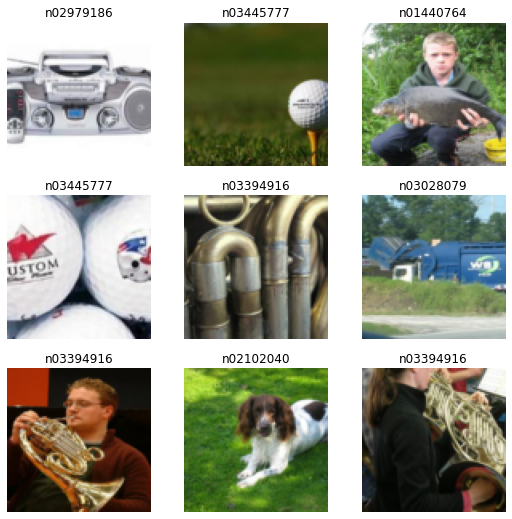

In [29]:
t2.show_batch()

### Test with no noise

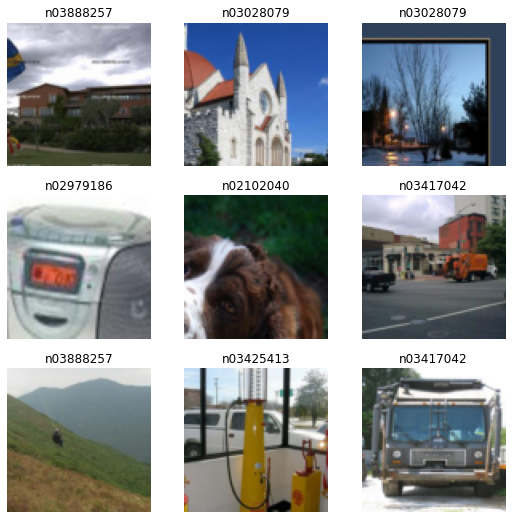

In [30]:
t3 = get_dls(size=90, woof=False, bs=10, pct_noise=0)
t3.show_batch()